In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import functools

from datetime import timedelta

import jax
import xarray

import numpy as np
import jax.numpy as jnp

from graphcast import xarray_jax

from data_loading import load_data
from model_running import (
    multi_step_forward_jit, forward_fn_jitted, build_static_data_selector,
    approx_forward_fn_jitted, task_config,
)
from attacks import add_perturbation, our_attack

In [3]:
era5 = xarray.open_zarr("gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr")

In [4]:
era5 = era5.isel(time=slice(1, None, 2))

In [5]:
single_sample = era5.isel(time=0).compute()
single_sample = single_sample.rename_dims(dict(latitude="lat", longitude="lon"))
single_sample = single_sample.rename_vars(dict(latitude="lat", longitude="lon"))
single_sample = single_sample.isel(lat=slice(None, None, -1))

In [6]:
inputs, targets, forcings = load_data(era5, "2005-08-27T06:00:00", task_config, lead_time=timedelta(days=2.5))

In [83]:
def general_loss_fn(
        rng,
        inputs,
        targets,
        forcings,
        forward_fn,
    ):
    denoised_predictions = multi_step_forward_jit(
        rng,
        inputs,
        targets,
        forcings,
        forward_fn
    ).isel(time=-1)

    # select target variable
    target = np.sqrt(denoised_predictions["10m_u_component_of_wind"]**2 + denoised_predictions["10m_v_component_of_wind"]**2)

    # select target region
    target = xarray_jax.unwrap_data(target, require_jax=True)
    minimize = build_static_data_selector(inputs.coords, 29, 31, -90, -87)(target)
    maximize = build_static_data_selector(inputs.coords, 29, 31, -95, -92)(target)

    loss = jnp.max(minimize) - jnp.max(maximize)
    return loss

# no jit, as it does not provide a speedup in this case
precise_loss_fn = lambda rng, i, t, f, s, v: general_loss_fn(rng, i, t, f, forward_fn_jitted, v, s)

def adv_grads_fn(rng, inputs, targets, forcings, approximation_steps):
    forward_fn = functools.partial(approx_forward_fn_jitted, approximation_steps=approximation_steps)
    def _aux(rng, i, t, f):
        loss = general_loss_fn(
            rng, i, t, f,
            forward_fn=forward_fn,
        )
        return loss

    loss, grads = jax.value_and_grad(
        _aux,
        argnums=1,
    )(rng, inputs, targets, forcings)
    return loss, grads
adv_grads_fn_jitted = jax.jit(adv_grads_fn, static_argnums=(4,))

In [8]:
import matplotlib.pyplot as plt

In [9]:
def calc_wind(x):
    # return np.sqrt(x["10m_u_component_of_wind"]**2 + x["10m_v_component_of_wind"]**2)
    return x["mean_sea_level_pressure"]

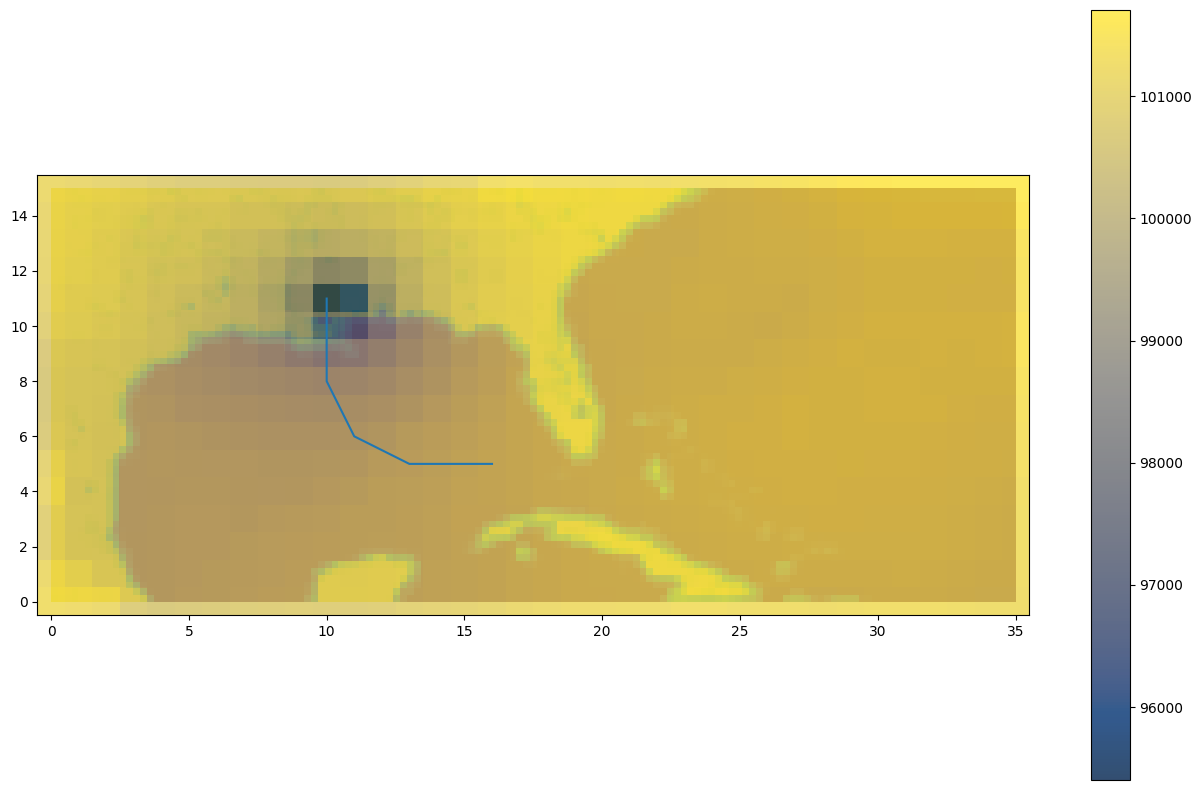

In [36]:
selected_mask = build_static_data_selector(single_sample.coords, 20, 35, -100, -65)(single_sample["land_sea_mask"].data)[::-1, ...]
fig, ax = plt.subplots(figsize=(16,10))
ax.imshow(selected_mask, extent=[0, 100-65, 0, 35-20])
points = []
points = []
for t in range(2):
    selected_wind = build_static_data_selector(inputs.coords, 20, 35, -100, -65)(calc_wind(inputs.isel(time=t, batch=0)).data)
    # point = np.unravel_index(selected_wind.argmax(), selected_wind.shape)
    point = np.unravel_index(selected_wind.argmin(), selected_wind.shape)
    points.append(point)
for t in range(4):
    selected_wind = build_static_data_selector(inputs.coords, 20, 35, -100, -65)(calc_wind(targets.isel(time=t, batch=0)).data)
    # point = np.unravel_index(selected_wind.argmax(), selected_wind.shape)
    point = np.unravel_index(selected_wind.argmin(), selected_wind.shape)
    points.append(point)
points = np.asarray(points)[..., ::-1]
ax.plot(*points[...].T)
selected_wind = build_static_data_selector(inputs.coords, 20, 35, -100, -65)(calc_wind(targets.isel(batch=0,time=-1)).data)
im = ax.imshow(selected_wind, cmap="cividis", alpha=0.8)
ax.invert_yaxis()
fig.colorbar(im)
real_path = points

In [84]:
perturbation = our_attack(
    inputs,
    targets,
    forcings,
    0.07,
    adv_grads_fn_jitted,
    maxiter=50,
    do_log=True,
)

0 11.965289
1 9.076604
2 -0.66368294
3 4.142988
4 -10.077076
5 3.4607363
6 6.881451
7 -4.5143156
8 -6.5139294
9 1.5699201
10 5.25029
11 -0.90763664
12 3.1309052
13 3.7458954
14 -3.3861327
15 -7.001671
16 -8.705261
17 -11.450837
18 -10.387226
19 -9.139288
20 -12.448943
21 -13.407707
22 -16.503206
23 -2.3447142
24 -11.139458
25 -13.853677
26 -15.579882
27 -11.672509
28 -15.198409
29 -15.509077
30 9.952922
31 -13.641985
32 -12.542717
33 4.7740507
34 -12.7418995
35 -1.968688
36 -13.651826
37 -16.843117
38 2.5018377
39 -11.757824
40 -16.048319
41 -11.448973
42 -13.471539
43 7.091114
44 -15.169346
45 -2.6558676
46 4.8489285
47 4.277611
48 -17.384563
49 -0.9087744


In [85]:
denoised_predictions = multi_step_forward_jit(
    jax.random.PRNGKey(1234567890),
    add_perturbation(inputs, perturbation),
    targets,
    forcings,
    forward_fn_jitted,
)

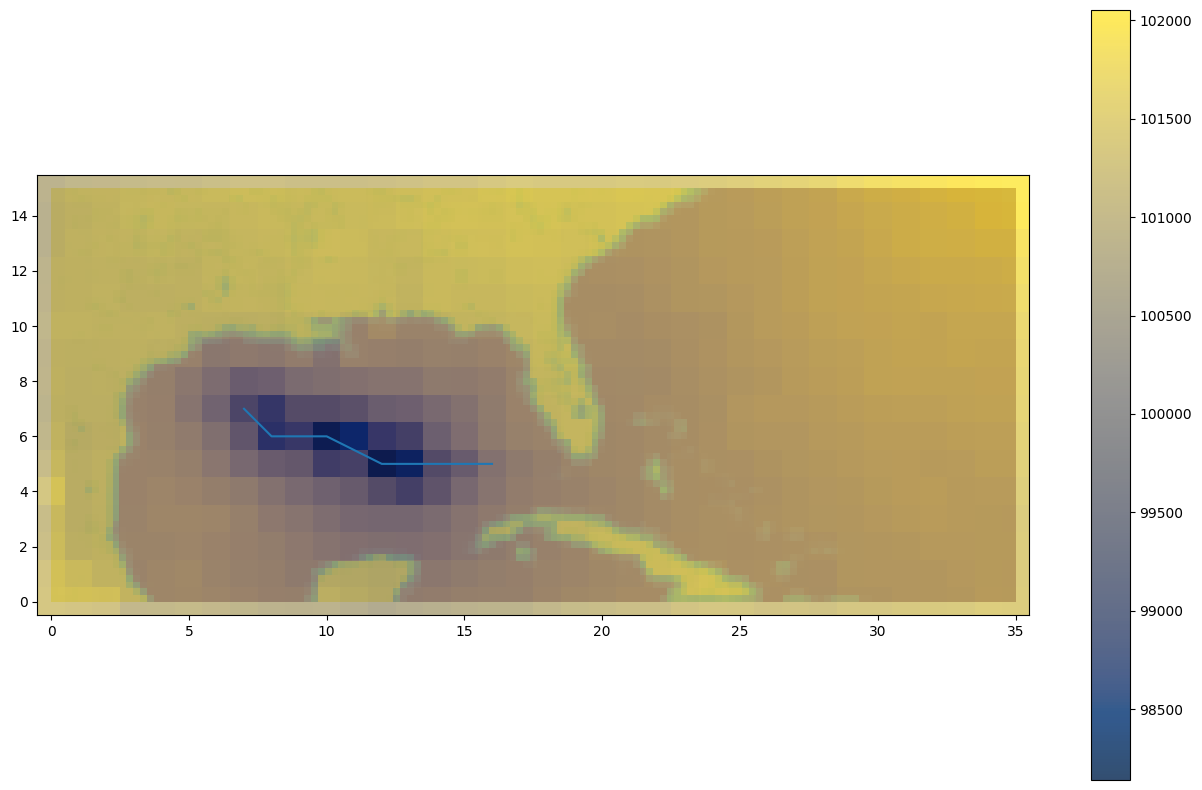

In [86]:
selected_mask = build_static_data_selector(single_sample.coords, 20, 35, -100, -65)(single_sample["land_sea_mask"].data)[::-1, ...]
fig, ax = plt.subplots(figsize=(16,10))
ax.imshow(selected_mask, extent=[0, 100-65, 0, 35-20])
points = []
for t in range(2):
    selected_wind = build_static_data_selector(inputs.coords, 20, 35, -100, -65)(calc_wind(inputs.isel(time=t, batch=0)).data)
    # point = np.unravel_index(selected_wind.argmax(), selected_wind.shape)
    point = np.unravel_index(selected_wind.argmin(), selected_wind.shape)
    points.append(point)
for t in range(4):
    selected_wind = build_static_data_selector(inputs.coords, 20, 35, -100, -65)(xarray_jax.unwrap_data(calc_wind(denoised_predictions.isel(time=t, batch=0))))
    # point = np.unravel_index(selected_wind.argmax(), selected_wind.shape)
    point = np.unravel_index(selected_wind.argmin(), selected_wind.shape)
    points.append(point)
points = np.asarray(points)[..., ::-1]
ax.plot(*points.T)

selected_wind = build_static_data_selector(inputs.coords, 20, 35, -100, -65)(xarray_jax.unwrap_data(calc_wind(denoised_predictions.isel(batch=0).min("time"))))
im = ax.imshow(selected_wind, cmap="cividis", alpha=0.8)
ax.invert_yaxis()
fig.colorbar(im)
perturbed_path = points

In [14]:
import json

with open("data/geoBoundariesCGAZ_ADM0.geojson", "r") as f:
    boundary_data = json.load(f)

In [15]:
name_to_idx = {
    boundary_data["features"][i]["properties"]["shapeName"]: i for i in range(len(boundary_data["features"]))
}

In [16]:
def smooth(points):
    new_points = [points[0]]
    def distance(p1, p2):
        return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
    for point in points[1:]:
        if distance(point, new_points[-1]) < 0.3:
            continue
        new_points.append(point)
    return new_points

def to_svg_path(points):
    assert len(points) == 1
    points = smooth(points[0])
    if len(points) <= 10:
        return ""
    assert len(points) > 1
    s = f"M{points[0][0]} {-points[0][1]}"
    for point in points[1:]:
        s += f" L{point[0]} {-point[1]}"
    s += " Z"
    return f'<path d="{s}" stroke="black" fill="#eee"/>'

In [101]:
def generate_arrows(points, color):
    arrows = []
    list(map(np.asarray, points))
    for start, end in zip(points, points[1:]):
        # add padding by slightly moving the end point
        end = end - 0.25 * (end - start) / np.linalg.norm(end - start)
        x1, y1 = start
        x2, y2 = end
        x1 += -100
        x2 += -100
        y1 += 20
        y2 += 20
        arrows.append(f'''<line y1="{-y1+0.5}" y2="{-y2+0.5}" marker-end="url(#arrow)" x2="{x2+0.5}" x1="{x1+0.5}" stroke="{color}" stroke-width="0.6%"/>''')
    return arrows

In [102]:
all_paths = sum(
    (
        list(map(to_svg_path, boundary_data["features"][name_to_idx[name]]["geometry"]["coordinates"]))
        for name in ["United States", "Mexico", "Cuba"]
    ), start=[]
)
with open("data/results/wind_case_study.svg", "w") as f:
    f.write(f'''<svg viewBox="-97 -32 17 8" xmlns="http://www.w3.org/2000/svg" style="stroke-width: 0.2%" clip-path="url(#clip)">
<defs>
    <clipPath id="clip" clipPathUnits="userSpaceOnUse">
        <rect x="0" y="0" width="100%" height="100%" rx="0.63" ry="0.55" />
    </clipPath>
    <marker xmlns="http://www.w3.org/2000/svg" id="arrow" viewBox="-4 0 4 7" refX="-0.5" refY="3.5" markerHeight="6" orient="auto" markerWidth="6">
      <!--<path d="M 0 0 L 10 5 L 0 10 L 5 5 z" stroke="context-stroke" fill="context-stroke"/>-->
      <g transform="matrix(1,0,0,1,-473.035,-238.062)" style="fill-rule:evenodd;clip-rule:evenodd;stroke-linecap:round;stroke-linejoin:round;stroke-miterlimit:10;">
        <g transform="matrix(1.33333,0,0,1.33333,0,0)">
            <g transform="matrix(-0.99998,-0.00026,0.00026,-0.99998,354.975,181.136)">
                <path d="M2.072,-2.391C1.694,-0.956 0.85,-0.279 0,0C0.85,0.279 1.694,0.956 2.072,2.391" style="fill:none;fill-rule:nonzero;stroke:context-stroke;stroke-width:0.4px;"/>
            </g>
        </g>
    </g>
    </marker>
    <marker
      id="tri"
      viewBox="0 0 10 10"
      refX="5"
      refY="5"
      orient="0"
      markerUnits="userSpaceOnUse"
      markerWidth="0.25"
      markerHeight="0.25">
      <path d="M 10 10 L 0 10 L 5 0 z" stroke="context-stroke" fill="context-stroke"/>
    </marker>
</defs>
    {"\n".join(all_paths)}
    {"\n".join(generate_arrows(perturbed_path, "#fc5a28"))}
    {"\n".join(generate_arrows(real_path, "#80b4e6"))}
    <line y1="-30.5" y2="-30.5" x1="-89.5" x2="-89.5" marker-end="url(#tri)" stroke="#80b4e6"/>
    <line y1="-30.5" y2="-30.5" x1="-94.5" x2="-94.5" marker-end="url(#tri)" stroke="#fc5a28"/>
    <rect x="-97" y="-32" width="17" height="8" rx="0.63" ry="0.55" stroke="black" fill="none"/>
</svg>''')